In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import pipeline

workdir =""
sns.set(style="darkgrid", font_scale=1.4)
random_state = 1

def write_to_csv(filename, array):
    np.savetxt(filename, array, delimiter="," , fmt='%f.3')

In [14]:
from sklearn import metrics, model_selection,  preprocessing

In [15]:
train_df = pd.read_csv(workdir + 'train.csv')
test_df = pd.read_csv(workdir + 'test.csv')

In [19]:
from sklearn import decomposition

In [20]:
prev_labels = ["VASK0_PREV", "VASK1_PREV", "VASK2_PREV", "VASK3_PREV", "VASK4_PREV",
               "VBID0_PREV", "VBID1_PREV", "VBID2_PREV", "VBID3_PREV", "VBID4_PREV"]

current_labels = ["VASK0", "VASK1", "VASK2", "VASK3", "VASK4",
                  "VBID0", "VBID1", "VBID2", "VBID3", "VBID4"]

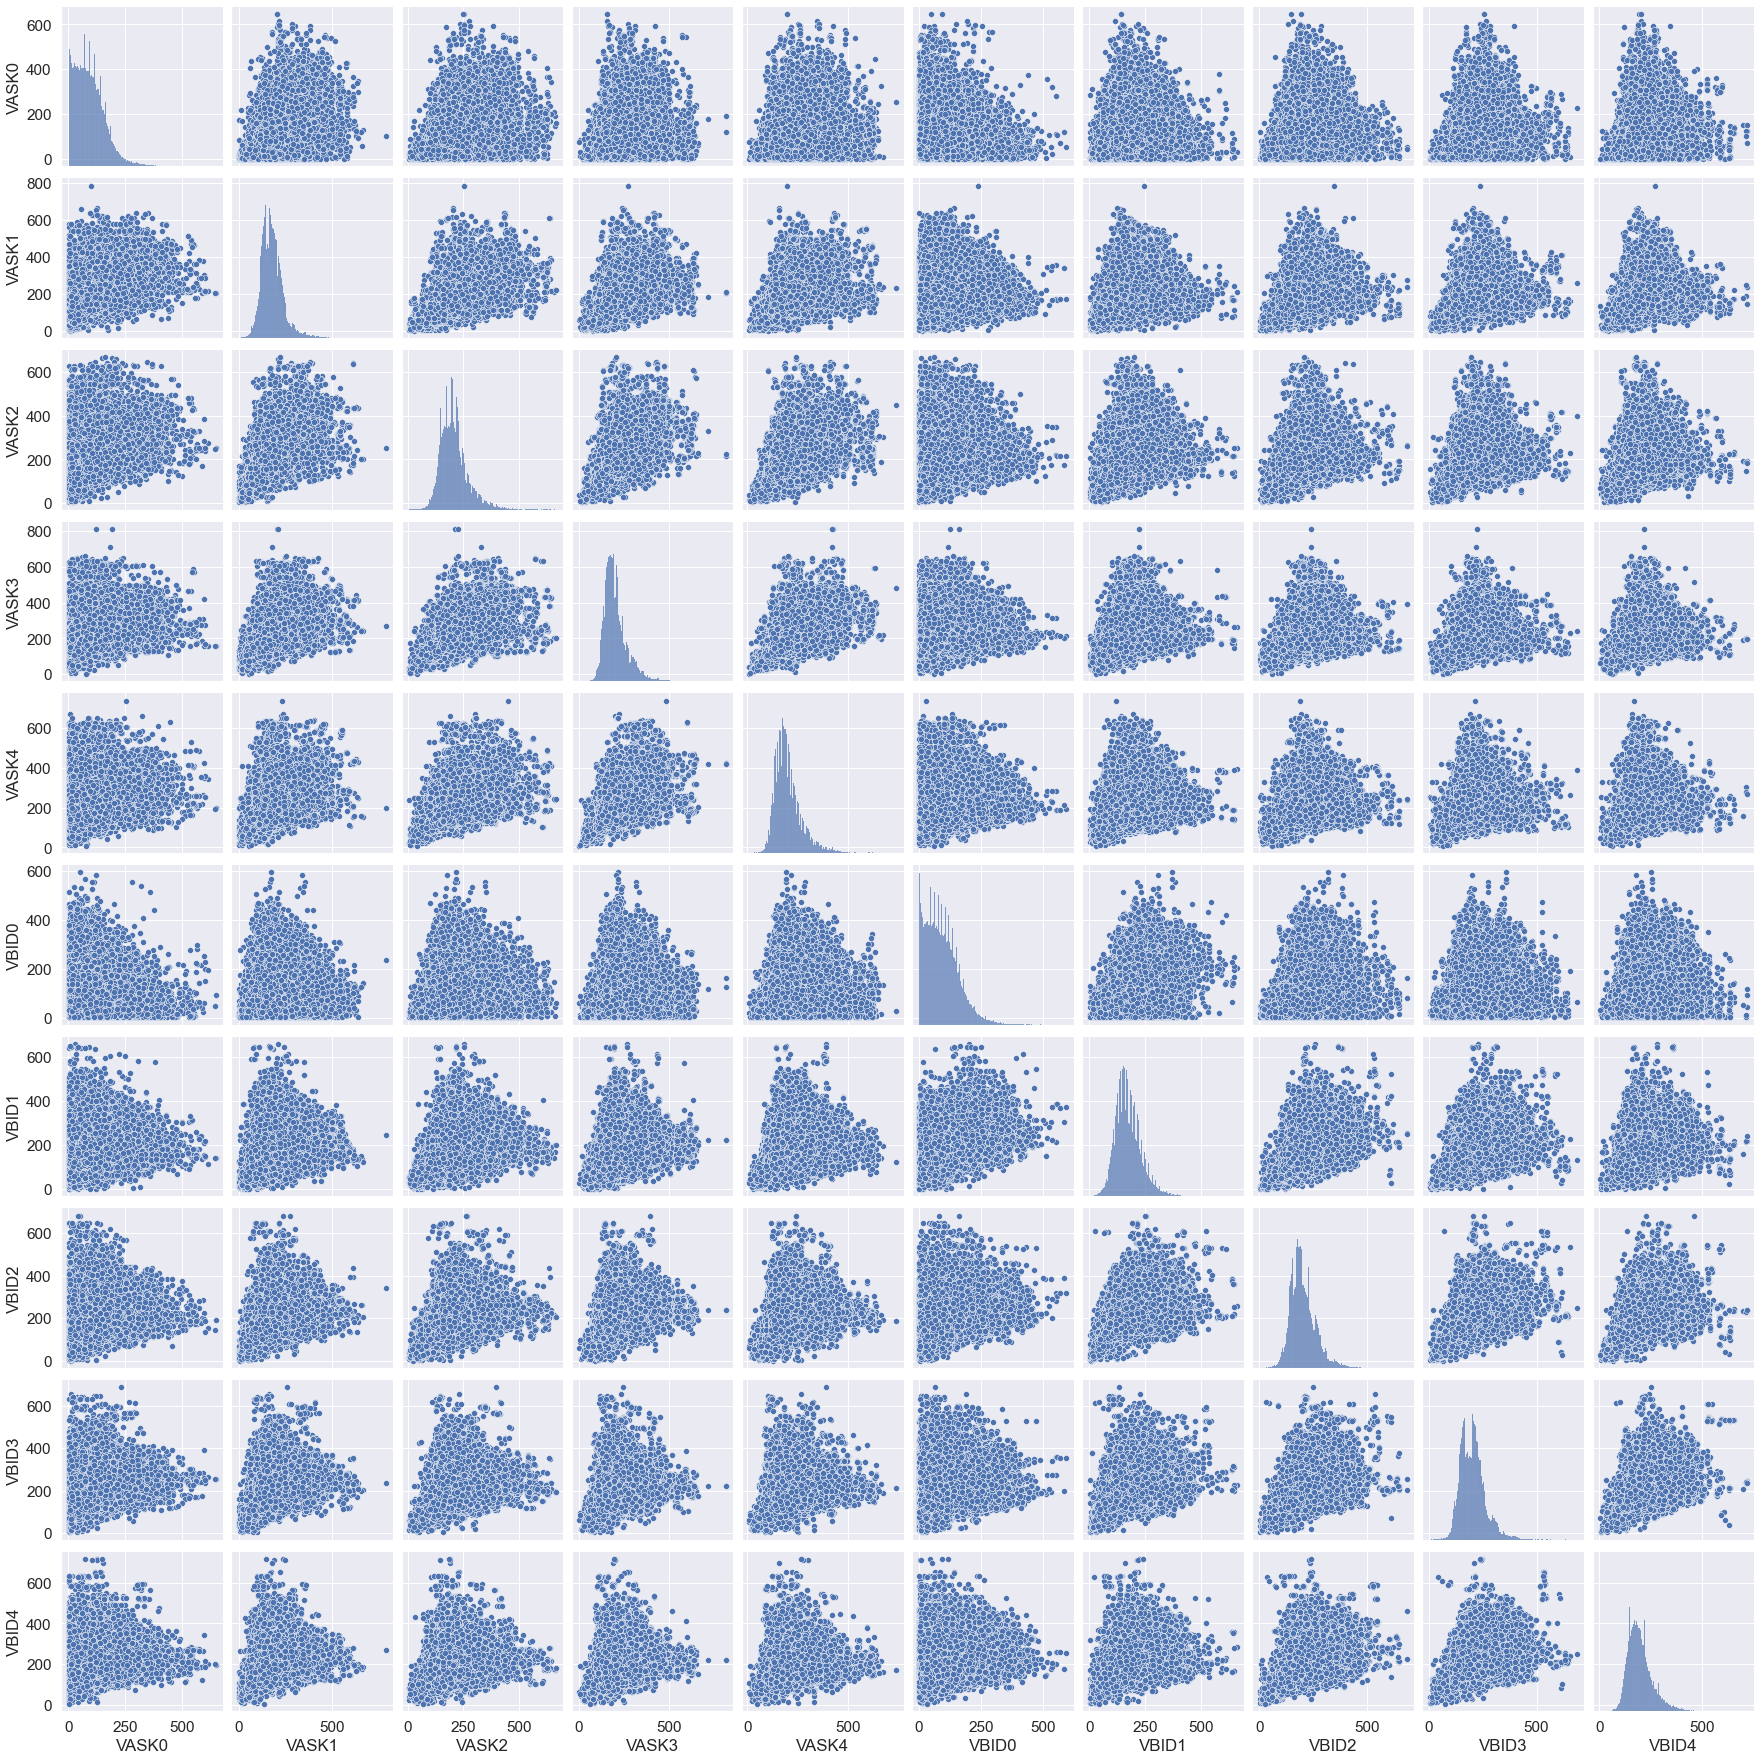

In [21]:
sns.pairplot(train_df, vars=current_labels)

In [25]:
X = train_df.values[:, :-1].astype(int)
y = train_df.values[:, -1]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, stratify=y, test_size=0.33)

print(X_train.shape, X_test.shape)

(125015, 20) (61575, 20)


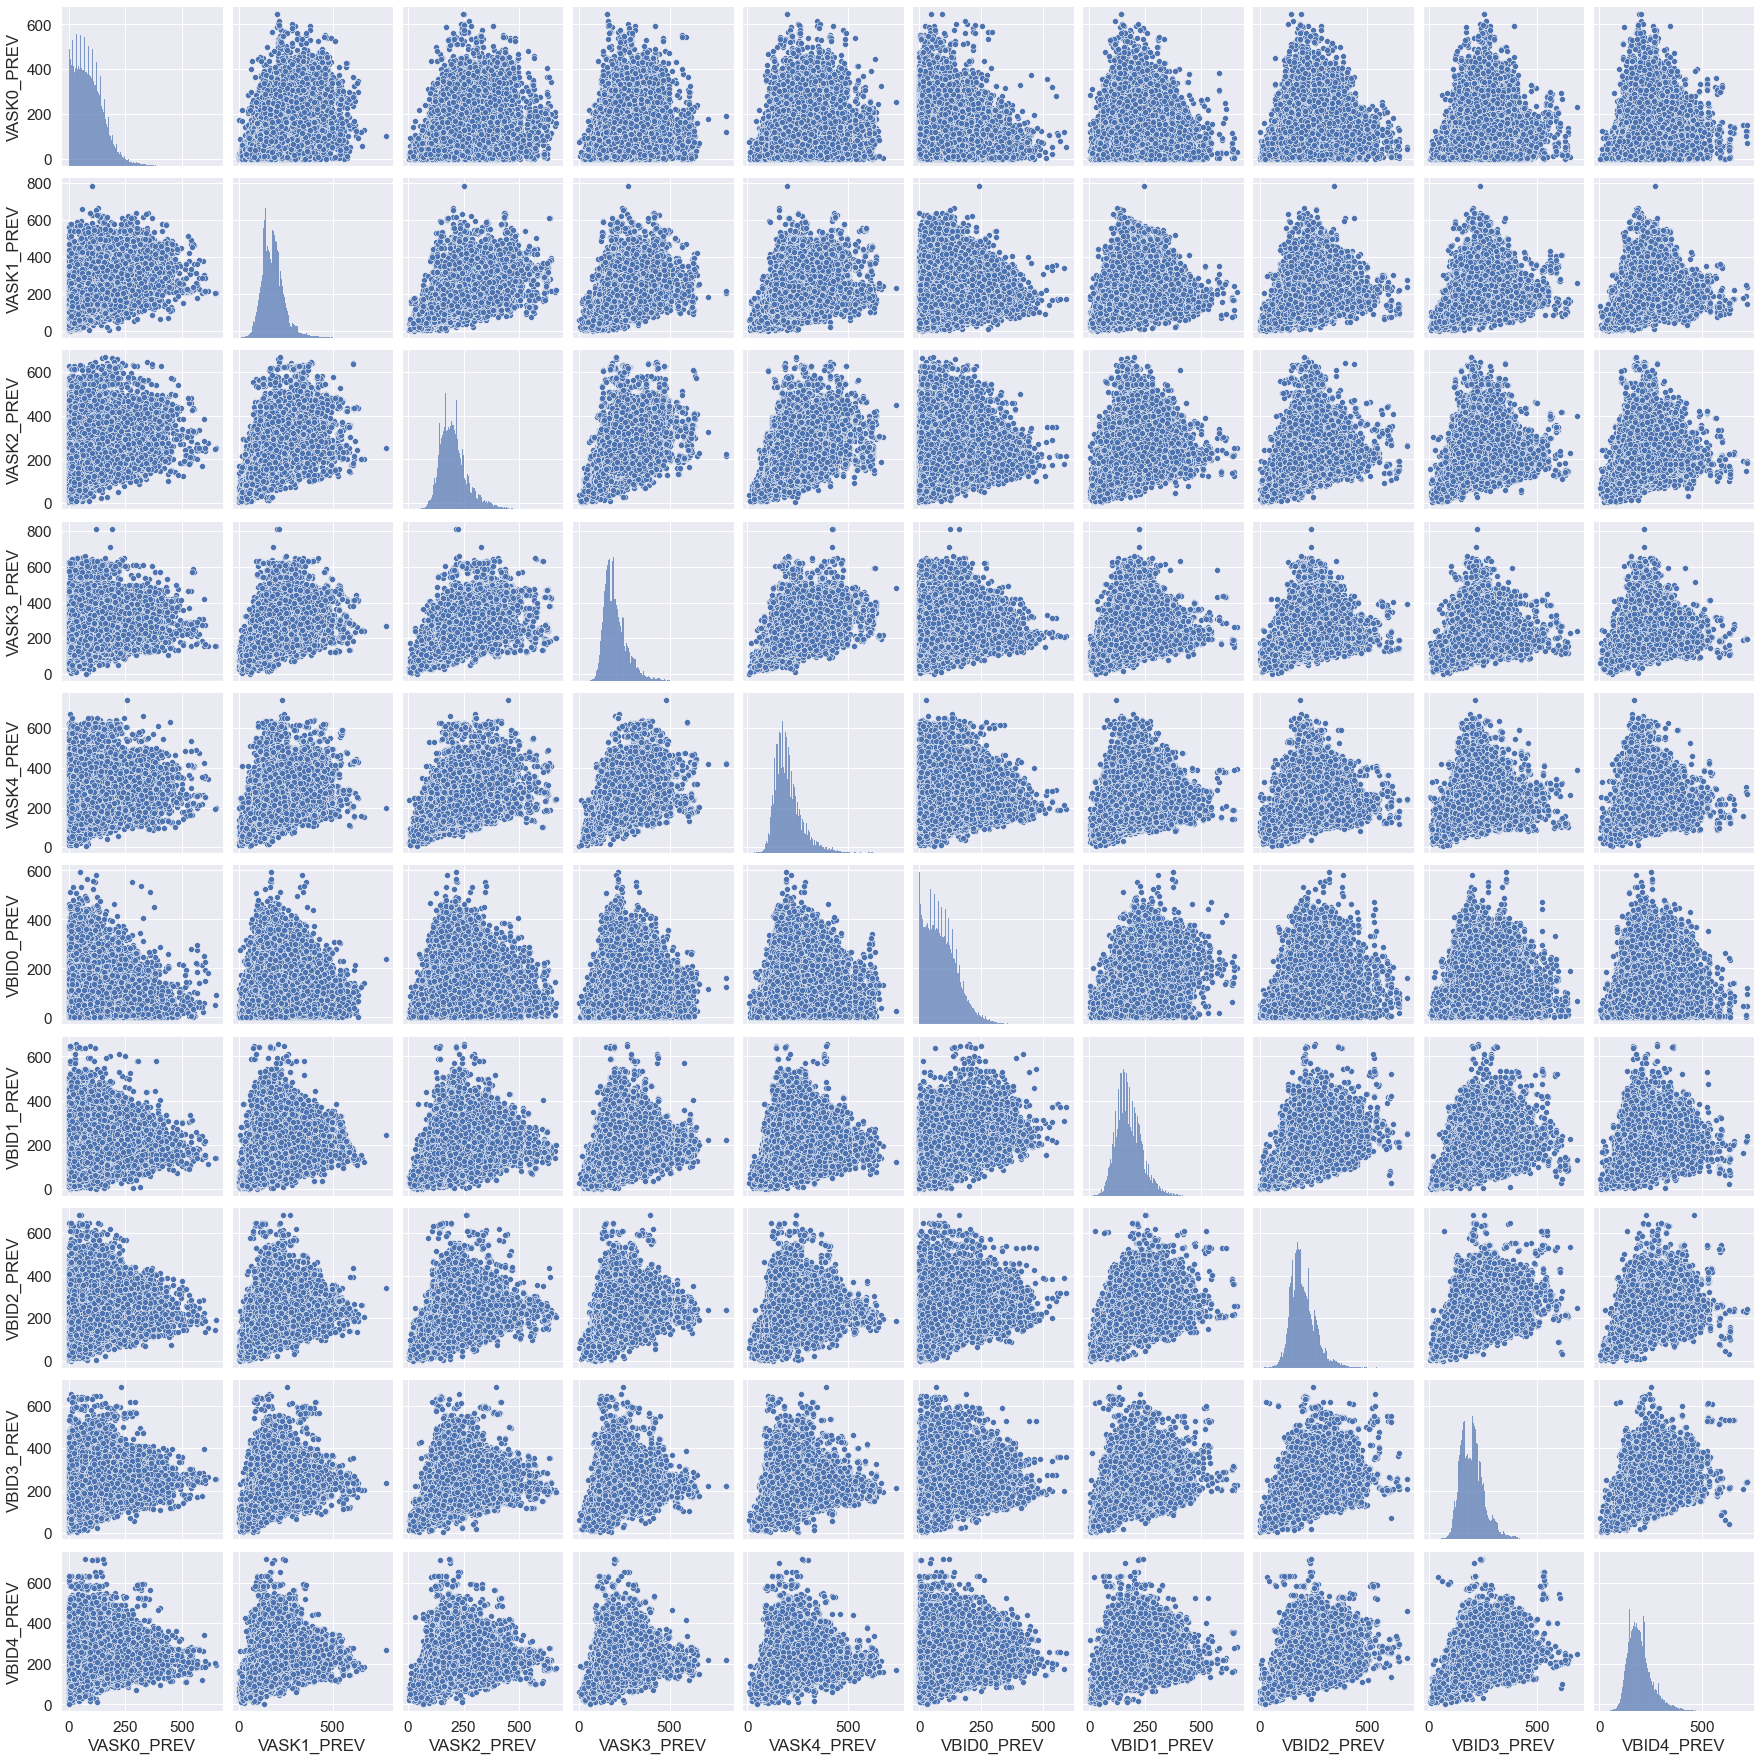

In [26]:
sns.pairplot(train_df, vars=prev_labels)

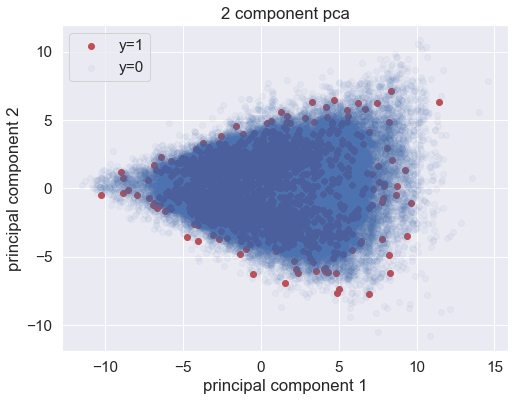

In [31]:
pca = decomposition.PCA(random_state= 1)
principalComponents = pca.fit_transform(preprocessing.StandardScaler().fit_transform(X))

plt.figure(figsize = (8,6))
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.title('2 component pca')

plt.scatter(principalComponents[y == 1, 0],
            principalComponents[y == 1, 1],
            color='r',
            label='y=1')

plt.scatter(principalComponents[ y== 0, 0],
            principalComponents[ y== 0, 1],
            color='b',
            label='y=0',
            alpha=0.05
            
           )
plt.legend()
plt.show()

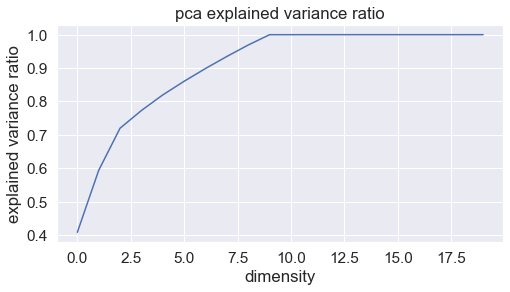

[0.40826049 0.59367094 0.71991229 0.77291569 0.81962339 0.86048035
 0.89864776 0.93471454 0.96898284 0.99986053 0.99990668 0.99994941
 0.99996159 0.99997134 0.99997964 0.99998703 0.99999153 0.99999533
 0.99999829 1.        ]


In [33]:
explained_var_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize = (8,4))
plt.plot(explained_var_ratio)
plt.title('pca explained variance ratio')
plt.xlabel('dimensity')
plt.ylabel('explained variance ratio')

plt.show()
print(explained_var_ratio)

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [42]:
rf = RandomForestClassifier(random_state=1, n_jobs=8)

In [43]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=8, random_state=1)

In [44]:
print('rf roc_auc score:', metrics.roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

rf roc_auc score: 0.8359395202655646


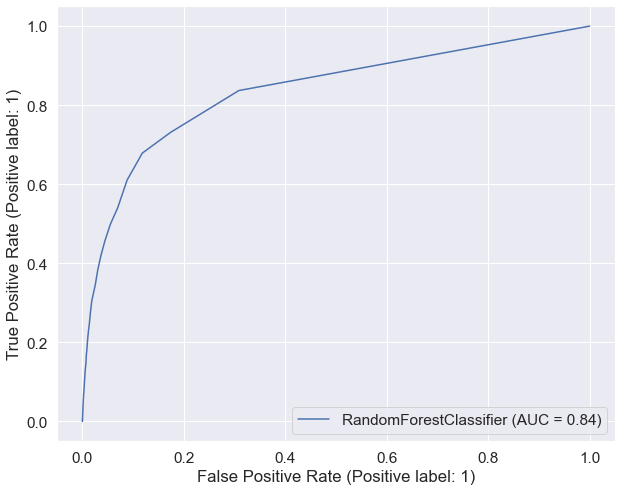

In [46]:
plt.figure(figsize=(10,8))
metrics.plot_roc_curve(estimator=rf, X=X_test, y=y_test, ax=plt.gca())
plt.show()

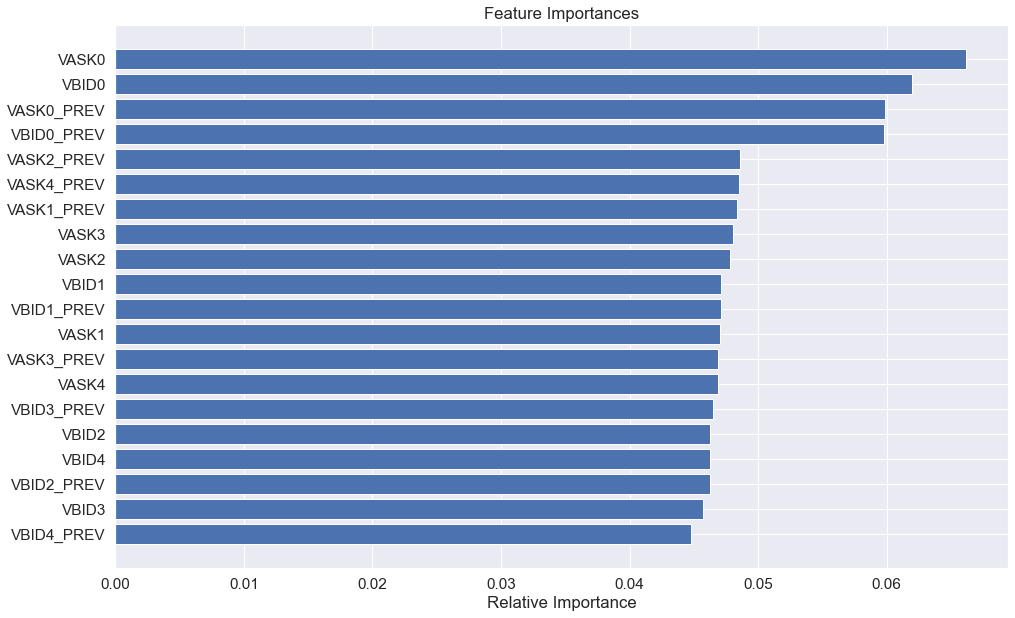

In [47]:
features = train_df.drop(["Y"], axis=1).columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(16, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [49]:
log_regr = LogisticRegression(random_state=1, n_jobs=8, solver="saga", max_iter=500, verbose=1)
scaler = preprocessing.StandardScaler()
pipe_logistic = pipeline.Pipeline(steps=[("scaler", scaler), ("logistic", log_regr)])

pipe_logistic

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic',
                 LogisticRegression(max_iter=500, n_jobs=8, random_state=1,
                                    solver='saga', verbose=1))])

In [50]:
param_grid = {
    "logistic__C" : np.logspace(-4, 4, 4),
    "logistic__penalty" : ["l1", "l2"]
}

cv = model_selection.StratifiedShuffleSplit(n_splits=2, test_size=0.33, random_state=random_state)
search = model_selection.GridSearchCV(pipe_logistic, param_grid, cv=cv, n_jobs=8, scoring="roc_auc")
search.fit(X, y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

pipe_logistic = search.best_estimator_

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


max_iter reached after 73 seconds
Best parameter (CV score=0.708):
{'logistic__C': 10000.0, 'logistic__penalty': 'l1'}


C:\Users\mocad\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:  1.2min finished


In [51]:
pipe_logistic.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


max_iter reached after 43 seconds


C:\Users\mocad\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   43.4s finished


Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic',
                 LogisticRegression(C=10000.0, max_iter=500, n_jobs=8,
                                    penalty='l1', random_state=1, solver='saga',
                                    verbose=1))])

Log regr roc_auc: 0.6976894471011197


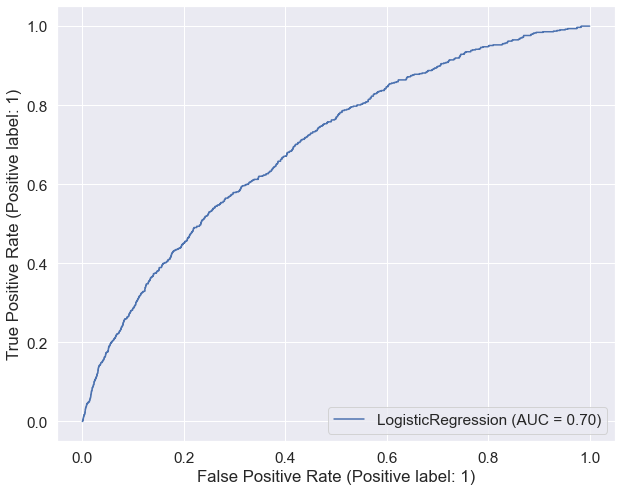

In [52]:
print("Log regr roc_auc:", metrics.roc_auc_score(y_test, pipe_logistic.predict_proba(X_test)[:, 1]))

plt.figure(figsize=(10,8))
metrics.plot_roc_curve(estimator=pipe_logistic["logistic"], X=pipe_logistic[:-1].transform(X_test), y=y_test, ax=plt.gca())
plt.show()

In [53]:
log_regr = LogisticRegression(random_state=random_state, n_jobs=8, solver="saga", max_iter=500, C=5, penalty="l2", verbose=1)
scaler = preprocessing.StandardScaler()
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)

pipe_logistic_poly = pipeline.Pipeline(steps=[("poly", poly), ("scaler", scaler), ("logistic", log_regr)])
pipe_logistic_poly

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('logistic',
                 LogisticRegression(C=5, max_iter=500, n_jobs=8, random_state=1,
                                    solver='saga', verbose=1))])

In [54]:
param_grid = {
    "logistic__C" : np.logspace(-4, 4, 4),
    "logistic__penalty" : ["l1", "l2"]
}

cv = model_selection.StratifiedShuffleSplit(n_splits=2, test_size=0.33, random_state=random_state)
search = model_selection.GridSearchCV(pipe_logistic_poly, param_grid, cv=cv, n_jobs=8, scoring="roc_auc")
search.fit(X, y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

pipe_logistic_poly = search.best_estimator_

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


max_iter reached after 450 seconds
Best parameter (CV score=0.880):
{'logistic__C': 21.54434690031882, 'logistic__penalty': 'l1'}


C:\Users\mocad\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:  7.5min finished


In [55]:
pipe_logistic_poly.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


max_iter reached after 298 seconds


C:\Users\mocad\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:  5.0min finished


Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('logistic',
                 LogisticRegression(C=21.54434690031882, max_iter=500, n_jobs=8,
                                    penalty='l1', random_state=1, solver='saga',
                                    verbose=1))])

Log regr roc_auc: 0.8854390448264896


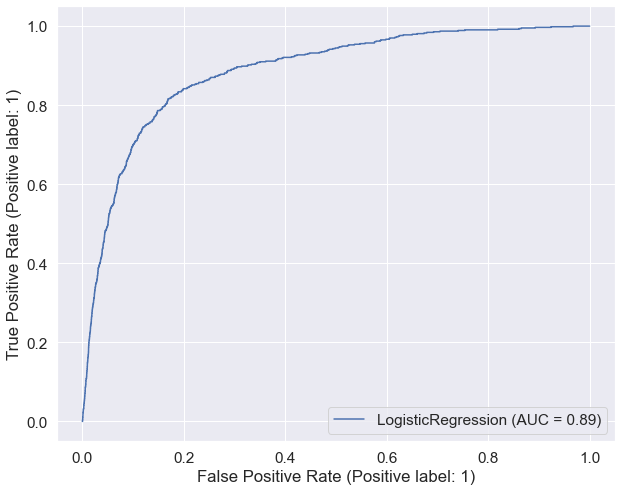

In [56]:
print("Log regr roc_auc:", metrics.roc_auc_score(y_test, pipe_logistic_poly.predict_proba(X_test)[:, 1]))

plt.figure(figsize=(10,8)) 
metrics.plot_roc_curve(estimator=pipe_logistic_poly["logistic"], X=pipe_logistic_poly[:-1].transform(X_test), y=y_test, ax=plt.gca())
plt.show()